# Projet 7 : Réalisez une analyse de sentiments grâce au Deep Learning
# Modèle sur mesure avancé

[Lien OpenClassroom](https://openclassrooms.com/fr/paths/795/projects/1516/1578-mission)

---

**Table of contents**<a id='toc0_'></a>    
- [Imports](#toc1_)    
- [Chargement des données](#toc2_)    
  - [Chargement du fichier csv](#toc2_1_)    
  - [Découpage du jeu de données](#toc2_2_)    
- [Préparation et Tests](#toc3_)    
  - [Variables Globales](#toc3_1_)    
  - [Fonctions de préprocessing](#toc3_2_)    
  - [ Test des approches de preprocessing](#toc3_3_)    
  - [Application du meilleur préprocessing](#toc3_4_)    
  - [Création d'un Tokenizer](#toc3_5_)    
  - [Sauvegarde du Tokenizer](#toc3_6_)    
  - [Chargement de GloVe Embeddings](#toc3_7_)    
  - [Création du modèle](#toc3_8_)    
- [Experiment 1: LSTM avec GloVe Embeddings](#toc4_)    
  - [MLFlow Setup](#toc4_1_)    
  - [Entrainement du modèle avec MLFlow](#toc4_2_)    
- [Experiment 2: LSTM avec Embeddings Vièrges Entrainable](#toc5_)    
  - [Entrainement du modèle avec MLFlow](#toc5_1_)    
- [Evaluation et Selection](#toc6_)    
  - [Selection du meilleur modèle (val_accuracy)](#toc6_1_)    
  - [Evaluation du modèle sur les données de Test](#toc6_2_)    
  - [Enregistrement du model](#toc6_3_)    
- [Dashboard MLFlow](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

---
---

## <a id='toc1_'></a>[Imports](#toc0_)

In [30]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    LSTM,
    Dense,
    Dropout,
    Embedding,
    Bidirectional,
    Input,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
import mlflow
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import contractions

try:
    stopwords.words("english")
except LookupError:
    nltk.download("stopwords")
try:
    word_tokenize("test")
except LookupError:
    nltk.download("punkt")
try:
    WordNetLemmatizer().lemmatize("cats")
except LookupError:
    nltk.download("wordnet")
    nltk.download("omw-1.4")

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

warnings.filterwarnings("ignore")
tf.get_logger().setLevel("ERROR")

---
---

## <a id='toc2_'></a>[Chargement des données](#toc0_)

---

### <a id='toc2_1_'></a>[Chargement du fichier csv](#toc0_)

In [31]:
DATA_PATH = "./data.csv"

df = pd.read_csv(DATA_PATH)

df.sample(10)

,tweet,label
1503830,"@teach24_7 1) every now &amp; again, for fun! ...",1
177381,"maybe someday. i lova ya, friends!! my compute...",0
340226,@MisterRo Does this mean that you aren't going...,0
1450680,@qillerm well... someone actually complained a...,1
816047,@stokez haha i know! ahh cant wait to go home!,1
1109101,goodnight everybody!!! buona notte!!,1
96580,I need to grow balls and learn to kiss people ...,0
910046,"having a creative party with me, myself, and moi",1
325867,"noticing some of the long-time java guys seem,...",0
121454,bah.. it's monday already,0


---

### <a id='toc2_2_'></a>[Découpage du jeu de données](#toc0_)

Cette cellule est une répétition de la logique de division des données déjà vue. Elle redéfinit et effectue le découpage du jeu de données en trois parties : entraînement, validation et test. L'objectif est de garantir que les données sont correctement et stratifiquement séparées pour le développement et l'évaluation des modèles, avec des proportions fixes (70% entraînement, 15% validation, 15% test). La séparation stratifiée est cruciale pour maintenir la distribution des classes de sentiment dans chaque ensemble, ce qui est important pour les jeux de données déséquilibrés. Enfin, les dimensions des ensembles et la distribution des sentiments sont imprimées pour vérification.

In [32]:
# Définir les features (X) et les labels (y)
X = df["tweet"]
y = df["label"]

# Définir les tailles des ensembles de test et de validation
TEST_SIZE = 0.15
VALIDATION_SIZE = 0.15  # Relatif à la taille originale du dataset

# Première division : entraînement vs. (validation + test)
# X_temp et y_temp contiennent les données destinées aux ensembles de validation et de test
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=(VALIDATION_SIZE + TEST_SIZE),  # Taille combinée de l'ensemble temporaire
    random_state=42,  # Pour garantir la reproductibilité des divisions
    stratify=y,  # Pour maintenir la même distribution de labels dans les sous-ensembles
)

# Calculer la proportion de l'ensemble de validation par rapport à l'ensemble temporaire
val_split_ratio = VALIDATION_SIZE / (VALIDATION_SIZE + TEST_SIZE)

# Deuxième division : validation vs. test à partir de l'ensemble temporaire
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=(
        1 - val_split_ratio
    ),  # La portion restante de X_temp devient l'ensemble de test
    random_state=42,
    stratify=y_temp,  # Maintenir la distribution des labels dans le sous-ensemble temporaire
)

# Afficher les formes des ensembles après la division
print("Division des données terminée :")
print(f"Taille de l'ensemble d'entraînement :   X={X_train.shape}, y={y_train.shape}")
print(f"Taille de l'ensemble de validation : X={X_val.shape}, y={y_val.shape}")
print(f"Taille de l'ensemble de test :       X={X_test.shape}, y={y_test.shape}")

# Afficher la distribution des sentiments dans chaque ensemble pour vérification
print("\nDistribution des sentiments dans les ensembles :")
print("Entraînement :\n", y_train.value_counts(normalize=True))
print("Validation :\n", y_val.value_counts(normalize=True))
print("Test :\n", y_test.value_counts(normalize=True))

Division des données terminée :
Taille de l'ensemble d'entraînement :   X=(1120000,), y=(1120000,)
Taille de l'ensemble de validation : X=(240000,), y=(240000,)
Taille de l'ensemble de test :       X=(240000,), y=(240000,)

Distribution des sentiments dans les ensembles :
Entraînement :
 label
1    0.5
0    0.5
Name: proportion, dtype: float64
Validation :
 label
0    0.5
1    0.5
Name: proportion, dtype: float64
Test :
 label
1    0.5
0    0.5
Name: proportion, dtype: float64


---
---

## <a id='toc3_'></a>[Préparation et Tests](#toc0_)

---

### <a id='toc3_1_'></a>[Variables Globales](#toc0_)

In [42]:
# Taille du vocabulaire à utiliser pour la tokenisation
VOCAB_SIZE = 300
# Longueur maximale des séquences de texte après padding/troncation
MAX_SEQUENCE_LENGTH = 20

# Chemin vers le fichier d'embeddings GloVe pré-entraînés
GLOVE_PATH = "./glove.6B.300d.txt"
# Dimension des vecteurs d'embeddings GloVe
EMBEDDING_DIM = 300

# Nombre d'époques d'entraînement pour le modèle
EPOCHS = 10
# Taille du lot (batch size) pour l'entraînement
BATCH_SIZE = 512

# Chemin d'artefact MLflow pour le tokenizer entraîné
TOKENIZER_ARTIFACT_PATH = "tokenizer"

# Chemin d'artefact MLflow pour le modèle de réseau de neurones entraîné
MODEL_ARTIFACT_PATH = "model"

---
### <a id='toc3_2_'></a>[Fonctions de préprocessing](#toc0_)

Cette cellule est une redéfinition des trois fonctions de prétraitement du texte (preprocess_full, preprocess_no_stopwords, preprocess_none) qui ont déjà été présentées. Elles sont cruciales pour la préparation des données textuelles avant l'entraînement des modèles de NLP.

preprocess_full : Effectue un nettoyage intensif, incluant la conversion en minuscules, l'expansion des contractions, la suppression des URLs, mentions, hashtags, nombres et caractères spéciaux, suivie de la tokenisation, de la suppression des mots vides et de la lemmatisation.

preprocess_no_stopwords : Similaire à preprocess_full, mais elle maintient les mots vides dans le texte final.

preprocess_none : Ne réalise aucun prétraitement, renvoyant le texte tel quel.

La présence répétée de cette cellule suggère qu'elle pourrait être exécutée à plusieurs reprises ou qu'elle est destinée à être un bloc de code réutilisable pour différents pipelines de modélisation dans le notebook.

In [34]:
def preprocess_full(text):
    """
    Applique toutes les étapes de nettoyage du texte, y compris la suppression des mots vides.
    """
    if not isinstance(text, str):
        return ""

    # Convertir le texte en minuscules
    text = text.lower()
    # Étendre les contractions (ex: "don't" -> "do not")
    text = contractions.fix(text)
    # Supprimer les URLs
    text = re.sub(r"http\S+|www\S+", "", text)
    # Supprimer les mentions (@user)
    text = re.sub(r"@\w+", "", text)
    # Supprimer les hashtags (#tag)
    text = re.sub(r"#\w+", "", text)
    # Supprimer les nombres
    text = re.sub(r"\d+", "", text)
    # Supprimer les caractères spéciaux et la ponctuation (ne garder que les lettres et espaces)
    text = re.sub(r"[^a-z\s]", "", text)

    # Tokeniser le texte en mots
    tokens = word_tokenize(text)
    cleaned_tokens = []
    for word in tokens:
        # Supprimer les mots vides et les mots d'une seule lettre, puis lemmatiser
        if len(word) > 1 and word not in stop_words:
            lemma = lemmatizer.lemmatize(word)
            cleaned_tokens.append(lemma)
    # Rejoindre les jetons nettoyés en une seule chaîne
    return " ".join(cleaned_tokens)


def preprocess_no_stopwords(text):
    """
    Applique toutes les étapes de nettoyage du texte, SAUF la suppression des mots vides.
    """
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)

    tokens = word_tokenize(text)
    cleaned_tokens = []
    for word in tokens:
        # Lemmatiser sans supprimer les mots vides
        if len(word) > 1:
            lemma = lemmatizer.lemmatize(word)
            cleaned_tokens.append(lemma)
    return " ".join(cleaned_tokens)


def preprocess_none(text):
    """
    N'applique aucun prétraitement, retourne le texte tel quel (ou une chaîne vide si ce n'est pas une chaîne).
    """
    if not isinstance(text, str):
        return ""
    return text

---

### <a id='toc3_3_'></a>[ Test des approches de preprocessing](#toc0_)

Cette cellule implémente le pipeline d'entraînement et d'évaluation pour un modèle de réseau de neurones LSTM, en explorant l'impact des différentes stratégies de prétraitement du texte.

create_lstm_model : Définit l'architecture du modèle LSTM. Il inclut une couche d'embedding qui peut soit utiliser des poids pré-entraînés (GloVe) et être figée (trainable=False), soit être initialisée aléatoirement et entraînée (trainable=True). Le modèle se compose ensuite d'une couche LSTM et d'une couche Dense de sortie avec activation sigmoïde pour la classification binaire.

train_eval_lstm : Gère l'ensemble du processus de préparation des données et d'entraînement/évaluation pour les modèles LSTM :

- Tokenisation et Padding : Crée un Tokenizer Keras pour convertir les textes en séquences numériques et padde ces séquences pour qu'elles aient une longueur uniforme (MAX_SEQUENCE_LENGTH).

- Chargement GloVe : La fonction tente de charger les embeddings GloVe et de construire une matrice d'embedding où chaque mot du vocabulaire du tokenizer est mappé à son vecteur GloVe correspondant.

- Construction et Entraînement du Modèle : Appelle create_lstm_model avec les paramètres appropriés (embeddings GloVe ou entraînables). Le modèle est ensuite entraîné sur les données padées.

- Évaluation : Prédit sur l'ensemble de test et calcule l'exactitude (accuracy) et le score F1.

Boucle de Benchmarking : La cellule itère sur les mêmes configurations de prétraitement que précédemment (preprocess_none, preprocess_no_stopwords, preprocess_full). Pour chaque configuration, elle exécute l'entraînement et l'évaluation du LSTM avec les embeddings GloVe. Les résultats sont stockés dans results_log.

L'objectif est d'évaluer la performance du modèle LSTM sous différentes conditions de prétraitement, afin de déterminer la combinaison optimale pour l'analyse de sentiment.

In [35]:
def create_lstm_model(
    vocab_size, embedding_dim, max_len, embedding_matrix=None, trainable_embedding=True
):
    """
    Crée un modèle LSTM de base pour la classification binaire.

    Args:
        vocab_size (int): Taille du vocabulaire.
        embedding_dim (int): Dimension des embeddings.
        max_len (int): Longueur maximale des séquences.
        embedding_matrix (np.array, optional): Matrice d'embeddings pré-entraînés.
        trainable_embedding (bool, optional): Indique si la couche d'embedding doit être entraînable.
    """
    model = Sequential()
    if embedding_matrix is not None:
        # Utiliser des embeddings pré-entraînés (non entraînables par défaut)
        model.add(
            Embedding(
                vocab_size,
                embedding_dim,
                weights=[embedding_matrix],
                input_length=max_len,
                trainable=False,  # Les poids des embeddings ne sont pas mis à jour
            )
        )
    else:
        # Utiliser une couche d'embedding entraînable à partir de zéro
        model.add(
            Embedding(
                vocab_size,
                embedding_dim,
                input_length=max_len,
                trainable=trainable_embedding,
            )
        )
    # Ajouter une couche LSTM
    model.add(LSTM(32))
    # Ajouter une couche de sortie Dense avec activation sigmoïde pour classification binaire
    model.add(Dense(1, activation="sigmoid"))

    # Compiler le modèle
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


def train_eval_lstm(
    X_train_processed, y_train_labels, X_test_processed, y_test_labels, use_glove=False
):
    """
    Entraîne et évalue un modèle LSTM, avec ou sans embeddings GloVe pré-entraînés.

    Args:
        X_train_processed (list): Textes d'entraînement prétraités.
        y_train_labels (pd.Series): Labels d'entraînement.
        X_test_processed (list): Textes de test prétraités.
        y_test_labels (pd.Series): Labels de test.
        use_glove (bool, optional): Utiliser les embeddings GloVe si True, sinon entraîner les embeddings.
    """
    print(
        f"Entraînement LSTM {'avec GloVe' if use_glove else 'avec Embeddings entraînables'}"
    )

    # Initialiser et entraîner le tokenizer sur les données d'entraînement
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<oov>")
    tokenizer.fit_on_texts(X_train_processed)
    word_index = tokenizer.word_index
    # Ajuster la taille réelle du vocabulaire si elle est inférieure à VOCAB_SIZE
    vocab_size = min(VOCAB_SIZE, len(word_index) + 1)

    # Convertir les textes en séquences numériques
    X_train_seq = tokenizer.texts_to_sequences(X_train_processed)
    X_test_seq = tokenizer.texts_to_sequences(X_test_processed)
    # Padder/tronquer les séquences pour avoir une longueur fixe
    X_train_pad = pad_sequences(
        X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post"
    )
    X_test_pad = pad_sequences(
        X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post"
    )

    embedding_matrix = None
    if use_glove:
        # Charger les embeddings GloVe
        embeddings_index = {}
        try:
            with open(GLOVE_PATH, encoding="utf-8") as f:
                for line in f:
                    values = line.split()
                    word = values[0]
                    coefs = np.asarray(values[1:], dtype="float32")
                    embeddings_index[word] = coefs
            print(f"Trouvé {len(embeddings_index)} vecteurs de mots dans {GLOVE_PATH}.")
        except FileNotFoundError:
            print(f"Erreur : Fichier GloVe introuvable à {GLOVE_PATH}")
            print("Expérience GloVe ignorée.")
            embeddings_index = None
        except Exception as e:
            print(f"Une erreur est survenue lors du chargement du fichier GloVe : {e}")
            embeddings_index = None

        if embeddings_index:
            print("Création de la matrice d'embeddings...")
            # Initialiser la matrice d'embeddings avec des zéros
            embedding_matrix = np.zeros(
                (min(VOCAB_SIZE, len(tokenizer.word_index) + 1), EMBEDDING_DIM)
            )
            hits = 0
            misses = 0
            # Remplir la matrice avec les vecteurs GloVe pour les mots du vocabulaire du tokenizer
            for word, i in tokenizer.word_index.items():
                if (
                    i >= vocab_size
                ):  # Ignorer les mots au-delà de la limite du vocabulaire
                    continue
                embedding_vector = embeddings_index.get(word)
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    hits += 1
                else:
                    misses += 1
            print(f"Converti {hits} mots ({misses} manquants)")
            print(f"Forme de la matrice d'embeddings : {embedding_matrix.shape}")

        # Créer le modèle LSTM avec les embeddings GloVe
        model = create_lstm_model(
            vocab_size,
            EMBEDDING_DIM,
            MAX_SEQUENCE_LENGTH,
            embedding_matrix=embedding_matrix,
            trainable_embedding=False,  # Embeddings GloVe non entraînables
        )
    else:
        # Créer le modèle LSTM avec des embeddings entraînables aléatoirement initialisés
        model = create_lstm_model(
            vocab_size, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH, trainable_embedding=True
        )

    # Entraîner le modèle LSTM
    model.fit(
        X_train_pad,
        y_train_labels,
        epochs=2,  # Époques réduites pour un exemple rapide
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,  # Ne pas afficher la barre de progression
    )

    # Faire des prédictions sur l'ensemble de test
    predictions_proba = model.predict(X_test_pad)
    predictions = (
        (predictions_proba > 0.5).astype(int).flatten()
    )  # Convertir les probabilités en classes
    true_labels = y_test_labels

    # Calculer l'exactitude et le score F1
    acc = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average="binary")
    return acc, f1


# Définir les différentes configurations de prétraitement à tester
preprocessing_configs = {
    "Sans Prétraitement": preprocess_none,
    "Tout Sauf Mots Vides": preprocess_no_stopwords,
    "Tout Prétraitement": preprocess_full,
}

results_log = []  # Liste pour stocker les résultats de l'évaluation

# Boucler sur chaque configuration de prétraitement
for pp_name, pp_function in preprocessing_configs.items():
    print(f"\n--- BENCHMARKING AVEC PRÉTRAITEMENT : {pp_name} ---")

    # Appliquer la fonction de prétraitement aux ensembles d'entraînement et de test
    current_X_train = [pp_function(text) for text in X_train]
    current_X_test = [pp_function(text) for text in X_test]

    # --- LSTM avec Embeddings GloVe ---
    acc, f1 = train_eval_lstm(
        current_X_train, y_train, current_X_test, y_test, use_glove=True
    )
    results_log.append(
        {
            "Modèle": "LSTM (GloVe Emb)",.
            "Prétraitement": pp_name,
            "Accuracy": acc,
            "F1-Score": f1,
        }
    )
    print(f"LSTM GloVe Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")


--- BENCHMARKING AVEC PRÉTRAITEMENT : Sans Prétraitement ---
Entraînement LSTM avec GloVe


2025/06/17 19:29:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2ee68e49a35342dead68760f3271964b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/06/17 19:29:55 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: Sequential model 'sequential_5' has no defined input shape yet.
2025/06/17 19:29:55 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Trouvé 400001 vecteurs de mots dans ./glove.6B.300d.txt.
Création de la matrice d'embeddings...
Converti 287 mots (12 manquants)
Forme de la matrice d'embeddings : (300, 300)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
LSTM GloVe Accuracy: 0.7382, F1-Score: 0.7451

--- BENCHMARKING AVEC PRÉTRAITEMENT : Tout Sauf Mots Vides ---
Entraînement LSTM avec GloVe


2025/06/17 19:33:51 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c43cd9b16aec43cbacc8b59b5711503e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/06/17 19:33:51 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: Sequential model 'sequential_6' has no defined input shape yet.
2025/06/17 19:33:51 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Trouvé 400001 vecteurs de mots dans ./glove.6B.300d.txt.
Création de la matrice d'embeddings...
Converti 298 mots (1 manquants)
Forme de la matrice d'embeddings : (300, 300)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
LSTM GloVe Accuracy: 0.7511, F1-Score: 0.7533

--- BENCHMARKING AVEC PRÉTRAITEMENT : Tout Prétraitement ---
Entraînement LSTM avec GloVe


2025/06/17 19:37:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '861671e563cd4ecebe426efdce4e33e4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/06/17 19:37:35 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: Sequential model 'sequential_7' has no defined input shape yet.
2025/06/17 19:37:35 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Trouvé 400001 vecteurs de mots dans ./glove.6B.300d.txt.
Création de la matrice d'embeddings...
Converti 297 mots (2 manquants)
Forme de la matrice d'embeddings : (300, 300)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
LSTM GloVe Accuracy: 0.7060, F1-Score: 0.7111


---

### <a id='toc3_4_'></a>[Application du meilleur préprocessing](#toc0_)

Cette cellule applique une étape de prétraitement spécifique aux ensembles de données textuelles (X_train, X_val, X_test). Elle utilise la fonction preprocess_no_stopwords qui nettoie les textes (minuscules, expansion des contractions, suppression des URLs, mentions, hashtags, nombres et ponctuation) mais, comme son nom l'indique, ne supprime pas les mots vides (stop words). Cela prépare les données pour des modèles qui pourraient bénéficier de la présence des mots vides pour le contexte, comme certains modèles de réseaux de neurones ou d'embeddings de mots qui capturent la sémantique de phrases entières.

In [36]:
# Appliquer la fonction de prétraitement 'preprocess_no_stopwords' aux ensembles d'entraînement, de validation et de test
# Cette fonction nettoie le texte mais conserve les mots vides.
X_train = [preprocess_no_stopwords(text) for text in X_train]
X_val = [preprocess_no_stopwords(text) for text in X_val]
X_test = [preprocess_no_stopwords(text) for text in X_test]

---

### <a id='toc3_5_'></a>[Création d'un Tokenizer](#toc0_)

Cette cellule gère la phase de tokenisation et de séquençage des données textuelles. Elle utilise le Tokenizer de Keras pour convertir les mots en identifiants numériques. Le tokenizer est ajusté uniquement sur l'ensemble d'entraînement pour éviter d'introduire des informations du test ou de la validation. Ensuite, tous les ensembles (entraînement, validation, test) sont transformés en séquences d'entiers et sont uniformisés en longueur via le padding (pad_sequences). Cela est essentiel pour préparer les données textuelles à être utilisées comme entrée pour des modèles de réseaux de neurones récurrents comme les LSTMs, qui nécessitent des entrées de longueur fixe. La taille effective du vocabulaire est également calculée et affichée.

In [37]:
# Initialiser le tokenizer Keras avec une taille de vocabulaire limitée et un jeton pour les mots hors-vocabulaire
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")

# Entraîner le tokenizer UNIQUEMENT sur les données d'entraînement pour éviter les fuites de données
tokenizer.fit_on_texts(X_train)

# Convertir les textes en séquences d'entiers basées sur le vocabulaire appris
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padder les séquences pour garantir une longueur uniforme (remplir après, tronquer après)
X_train_pad = pad_sequences(
    X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post"
)
X_val_pad = pad_sequences(
    X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post"
)
X_test_pad = pad_sequences(
    X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post"
)

# Calculer la taille réelle du vocabulaire (incluant le jeton de padding)
# Limité par VOCAB_SIZE ou la taille réelle du vocabulaire si elle est plus petite
actual_vocab_size = min(VOCAB_SIZE, len(tokenizer.word_index) + 1)
print(f"Taille du vocabulaire réelle utilisée : {actual_vocab_size}")
print(f"Forme des séquences d'entraînement padées : {X_train_pad.shape}")
print(f"Forme des séquences de validation padées : {X_val_pad.shape}")
print(f"Forme des séquences de test padées : {X_test_pad.shape}")

Taille du vocabulaire réelle utilisée : 300
Forme des séquences d'entraînement padées : (1120000, 20)
Forme des séquences de validation padées : (240000, 20)
Forme des séquences de test padées : (240000, 20)


---

### <a id='toc3_7_'></a>[Chargement de GloVe Embeddings](#toc0_)

Cette cellule est dédiée à la préparation de la matrice d'embeddings pré-entraînés GloVe. Elle tente d'abord de charger les vecteurs de mots depuis le fichier spécifié par GLOVE_PATH. Si le fichier est trouvé, il est parcouru ligne par ligne pour extraire les mots et leurs vecteurs correspondants, stockés dans un dictionnaire embeddings_index. En cas d'erreur (fichier non trouvé ou autre), un message est affiché et le processus GloVe est ignoré.

Après le chargement (réussi), une matrice d'embedding (embedding_matrix) est créée. Cette matrice est dimensionnée pour correspondre au vocabulaire de notre tokenizer (actual_vocab_size) et à la dimension des embeddings (EMBEDDING_DIM). Elle est ensuite remplie : pour chaque mot présent dans le vocabulaire de notre tokenizer et trouvé dans les embeddings GloVe, le vecteur GloVe correspondant est copié dans la matrice. Les mots du vocabulaire du tokenizer qui ne sont pas trouvés dans GloVe sont représentés par des vecteurs de zéros dans la matrice d'embedding. Le nombre de "hits" (mots trouvés) et de "misses" (mots non trouvés) est affiché pour donner une idée de la couverture du vocabulaire par GloVe. Cette matrice sera ensuite utilisée pour initialiser la couche d'embedding de notre modèle de réseau de neurones.

In [38]:
# Initialiser un dictionnaire pour stocker les embeddings GloVe
embeddings_index = {}
try:
    # Ouvrir le fichier GloVe et parser chaque ligne
    with open(GLOVE_PATH, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs
    print(f"Trouvé {len(embeddings_index)} vecteurs de mots dans {GLOVE_PATH}.")
except FileNotFoundError:
    print(f"Erreur : Fichier GloVe introuvable à {GLOVE_PATH}")
    print("Expérience GloVe ignorée.")
    embeddings_index = None  # S'assurer que la variable existe mais est None
except Exception as e:
    print(f"Une erreur est survenue lors du chargement du fichier GloVe : {e}")
    embeddings_index = None

# Créer la matrice d'embeddings à partir des embeddings GloVe et du vocabulaire du tokenizer
embedding_matrix = None
if embeddings_index:
    print("Création de la matrice d'embeddings...")
    # Initialiser la matrice d'embeddings avec des zéros
    embedding_matrix = np.zeros((actual_vocab_size, EMBEDDING_DIM))
    hits = 0
    misses = 0
    # Remplir la matrice avec les vecteurs GloVe pour les mots présents dans le vocabulaire de notre tokenizer
    for word, i in tokenizer.word_index.items():
        if (
            i >= actual_vocab_size
        ):  # Ignorer les mots au-delà de la taille de vocabulaire définie
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Les mots trouvés dans GloVe reçoivent leur vecteur
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            # Les mots non trouvés dans GloVe restent avec un vecteur de zéros
            misses += 1
    print(f"Converti {hits} mots ({misses} manquants)")
    print(f"Forme de la matrice d'embeddings : {embedding_matrix.shape}")

Trouvé 400001 vecteurs de mots dans ./glove.6B.300d.txt.
Création de la matrice d'embeddings...
Converti 298 mots (1 manquants)
Forme de la matrice d'embeddings : (300, 300)


---

### <a id='toc3_8_'></a>[Création du modèle](#toc0_)

Cette cellule définit la fonction build_lstm_model qui construit une architecture de réseau de neurones LSTM pour la classification de texte. Le modèle intègre une couche d'embedding qui peut être initialisée avec des poids pré-entraînés (par exemple, GloVe) et figée, ou entraînée à partir de zéro. L'architecture optimisée comprend deux couches LSTM (la première retournant des séquences, la seconde non), suivies d'une couche Dense avec activation ReLU, d'une couche Dropout pour la régularisation, et enfin d'une couche Dense de sortie avec activation sigmoïde pour la classification binaire. Le modèle est compilé avec une perte de 'binary_crossentropy', l'optimiseur 'adamax' et la métrique 'accuracy'.

In [47]:
def build_lstm_model(
    vocab_size,
    embedding_dim,
    max_length,
    embedding_matrix=None,
    is_embedding_trainable=False,
):
    """
    Construit un modèle LSTM optimisé pour la classification de texte.

    Args:
        vocab_size (int): Taille du vocabulaire.
        embedding_dim (int): Dimension des embeddings.
        max_length (int): Longueur maximale des séquences d'entrée.
        embedding_matrix (np.array, optional): Matrice d'embeddings pré-entraînés.
        is_embedding_trainable (bool, optional): Si la couche d'embedding doit être entraînable.
    """

    model = Sequential()

    # Couche d'entrée pour définir la forme des séquences
    model.add(Input(shape=(max_length,)))

    # Couche d'embedding
    if embedding_matrix is not None:
        print("Utilisation de la matrice d'embeddings pré-entraînés.")
        model.add(
            Embedding(
                input_dim=vocab_size,
                output_dim=embedding_dim,
                weights=[embedding_matrix],  # Utiliser les poids pré-entraînés
                input_length=max_length,
                trainable=is_embedding_trainable,  # Définir si les poids sont mis à jour
            )
        )
    else:
        print("Utilisation d'une couche d'embeddings entraînables.")
        model.add(
            Embedding(
                input_dim=vocab_size,
                output_dim=embedding_dim,
                input_length=max_length,
                trainable=is_embedding_trainable,
            )
        )

    # Deuxième couche LSTM avec dropout récurrent (ne retourne pas de séquences)
    model.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.1)))

    # Couche de sortie Dense pour la classification binaire (activation sigmoïde)
    model.add(Dense(1, activation="sigmoid"))

    # Compiler le modèle avec une fonction de perte binaire, un optimiseur et des métriques
    model.compile(loss="binary_crossentropy", optimizer="adamax", metrics=["accuracy"])

    return model

---

### <a id='toc4_1_'></a>[MLFlow Setup](#toc0_)

In [48]:
# Nom de l'expérience MLflow pour le suivi des modèles de Deep Learning avancés
EXPERIMENT_NAME = "Tweet Sentiment Analysis - Advanced DL"
# Définir l'expérience MLflow actuelle
mlflow.set_experiment(EXPERIMENT_NAME)
print(f"Expérience MLflow définie sur : '{EXPERIMENT_NAME}'")

Expérience MLflow définie sur : 'Tweet Sentiment Analysis - Advanced DL'


---
---

## <a id='toc4_'></a>[Experiment 1: LSTM avec GloVe Embeddings](#toc0_)

---

### <a id='toc4_2_'></a>[Entrainement du modèle avec MLFlow](#toc0_)

Cette cellule lance une exécution MLflow dédiée à l'entraînement et à la journalisation d'un modèle LSTM utilisant des embeddings GloVe pré-entraînés.

Configuration MLflow : Elle définit un nom pour l'exécution et active l'autologging de TensorFlow/Keras, ce qui permet à MLflow de capturer automatiquement les hyperparamètres, métriques et le modèle lui-même.

Paramètres de l'Expérience : Plusieurs paramètres clés liés à l'architecture du modèle (type d'embedding, taille du vocabulaire, longueur de séquence, etc.) et au processus d'entraînement (époques, batch size) sont explicitement loggés dans MLflow.

Construction du Modèle : Le modèle LSTM est construit en utilisant la fonction build_lstm_model, en lui passant la matrice d'embeddings GloVe pré-entraînée. Les embeddings sont configurés pour être non entraînables.

Entraînement : Le modèle est entraîné sur l'ensemble d'entraînement (X_train_pad, y_train), avec l'ensemble de validation (X_val_pad, y_val) utilisé pour le suivi des performances. Un callback EarlyStopping est mis en place pour arrêter l'entraînement si la précision de validation ne s'améliore pas après un certain nombre d'époques, aidant à prévenir le surapprentissage.

Journalisation des Artefacts : Après l'entraînement, le tokenizer Keras (essentiel pour convertir de nouveaux textes en séquences numériques pour la prédiction) est sauvegardé localement puis journalisé en tant qu'artefact MLflow.

L'objectif de cette exécution est d'entraîner et d'enregistrer un modèle LSTM performant avec des embeddings GloVe, tout en capturant toutes les métadonnées et artefacts pertinents dans MLflow pour une traçabilité complète et une reproductibilité future.

In [49]:
# Nom de l'exécution MLflow pour ce modèle spécifique
run_name = "LSTM_GloVe_Embeddings"

print(f"\n--- Démarrage de l'exécution MLflow pour : {run_name} ---")

# Activer l'autologging pour TensorFlow/Keras avec MLflow
# Cela permet à MLflow de logger automatiquement les paramètres, métriques et modèles
mlflow.tensorflow.autolog(
    log_models=True,  # Journaliser le modèle entraîné
    disable=False,
    registered_model_name=None,  # Ne pas enregistrer automatiquement dans le registre de modèles
)

# Démarrer une nouvelle exécution MLflow
with mlflow.start_run(run_name=run_name) as run:
    run_id = run.info.run_id
    print(f"ID de l'exécution MLflow (GloVe) : {run_id}")

    # --- Enregistrer les paramètres de l'expérience ---
    mlflow.log_param("type_embedding", "GloVe (Non Entraînable)")
    mlflow.log_param("taille_vocabulaire", actual_vocab_size)
    mlflow.log_param("longueur_max_sequence", MAX_SEQUENCE_LENGTH)
    mlflow.log_param("dimension_embedding", EMBEDDING_DIM)
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("taille_batch", BATCH_SIZE)
    mlflow.log_param("architecture", "Input-Embedding-LSTM-LSTM-Dense-Dropout-Dense")

    # --- Construire le modèle ---
    model_glove = build_lstm_model(
        vocab_size=actual_vocab_size,
        embedding_dim=EMBEDDING_DIM,
        max_length=MAX_SEQUENCE_LENGTH,
        embedding_matrix=embedding_matrix,  # Utiliser la matrice GloVe
        is_embedding_trainable=False,  # Les embeddings GloVe ne sont pas entraînables
    )

    # --- Callbacks d'entraînement ---
    # Arrêt précoce basé sur la précision de validation
    early_stopping = EarlyStopping(
        monitor="val_accuracy", patience=3, restore_best_weights=True
    )

    # --- Entraîner le modèle ---
    print("\nEntraînement du modèle LSTM avec embeddings GloVe...")
    history_glove = model_glove.fit(
        X_train_pad,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val_pad, y_val),
        callbacks=[early_stopping],
        verbose=2,  # Afficher les logs d'entraînement par époque
    )
    print("Entraînement du modèle GloVe terminé.")

    # --- Sauvegarder et journaliser le tokenizer ---
    # Sauvegarder le tokenizer localement (nécessaire pour recréer l'environnement de prédiction)
    with open("./advance_exp_1_tokenizer.pkl", "wb") as f:
        pickle.dump(tokenizer, f)
    # Journaliser le tokenizer en tant qu'artefact MLflow
    mlflow.log_artifact(
        "advance_exp_1_tokenizer.pkl", artifact_path=TOKENIZER_ARTIFACT_PATH
    )

    print(f"--- Exécution MLflow {run_id} terminée ---")

2025/06/17 20:10:11 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'



--- Démarrage de l'exécution MLflow pour : LSTM_GloVe_Embeddings ---
ID de l'exécution MLflow (GloVe) : 62b7b12d38624eb4959f52a64e2d39f4
Utilisation de la matrice d'embeddings pré-entraînés.

Entraînement du modèle LSTM avec embeddings GloVe...


Epoch 1/10


2188/2188 - 93s - 42ms/step - accuracy: 0.7213 - loss: 0.5420 - val_accuracy: 0.7395 - val_loss: 0.5149
Epoch 2/10


2188/2188 - 93s - 42ms/step - accuracy: 0.7404 - loss: 0.5152 - val_accuracy: 0.7474 - val_loss: 0.5028
Epoch 3/10


2188/2188 - 92s - 42ms/step - accuracy: 0.7464 - loss: 0.5056 - val_accuracy: 0.7502 - val_loss: 0.4984
Epoch 4/10


2188/2188 - 92s - 42ms/step - accuracy: 0.7508 - loss: 0.4993 - val_accuracy: 0.7546 - val_loss: 0.4923
Epoch 5/10
2188/2188 - 92s - 42ms/step - accuracy: 0.7537 - loss: 0.4947 - val_accuracy: 0.7544 - val_loss: 0.4927
Epoch 6/10


2188/2188 - 94s - 43ms/step - accuracy: 0.7564 - loss: 0.4908 - val_accuracy: 0.7570 - val_loss: 0.4892
Epoch 7/10


2188/2188 - 94s - 43ms/step - accuracy: 0.7582 - loss: 0.4877 - val_accuracy: 0.7600 - val_loss: 0.4848
Epoch 8/10


2188/2188 - 95s - 44ms/step - accuracy: 0.7598 - loss: 0.4851 - val_accuracy: 0.7615 - val_loss: 0.4832
Epoch 9/10


2188/2188 - 95s - 43ms/step - accuracy: 0.7613 - loss: 0.4828 - val_accuracy: 0.7625 - val_loss: 0.4820
Epoch 10/10
2188/2188 - 95s - 43ms/step - accuracy: 0.7628 - loss: 0.4804 - val_accuracy: 0.7618 - val_loss: 0.4824
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
Entraînement du modèle GloVe terminé.
--- Exécution MLflow 62b7b12d38624eb4959f52a64e2d39f4 terminée ---


---
---

## <a id='toc5_'></a>[Experiment 2: LSTM avec Embeddings Vièrges Entrainable](#toc0_)

---

### <a id='toc5_1_'></a>[Entrainement du modèle avec MLFlow](#toc0_)

Cette cellule est une deuxième exécution MLflow pour l'entraînement d'un modèle LSTM, cette fois-ci avec des embeddings entraînables plutôt que pré-entraînés.

Configuration MLflow : Similaire à la cellule précédente, elle définit un nom d'exécution (LSTM_Trainable_Embeddings) et active l'autologging de TensorFlow/Keras.

Paramètres de l'Expérience : Les paramètres du modèle et du processus d'entraînement sont loggés, notamment la taille_vocabulaire, longueur_max_sequence, dimension_embedding, etc. Une note d'incohérence est signalée concernant la description de l'architecture par rapport à la fonction build_lstm_model.

Construction du Modèle : Le modèle LSTM est construit en appelant build_lstm_model avec embedding_matrix=None et is_embedding_trainable=True. Cela indique à la couche d'embedding d'être initialisée aléatoirement et d'ajuster ses poids pendant l'entraînement.

Entraînement : Le modèle est entraîné sur l'ensemble d'entraînement avec validation sur l'ensemble de validation, et utilise également l'EarlyStopping pour éviter le surapprentissage.

Journalisation des Artefacts : Le tokenizer Keras est de nouveau sauvegardé localement et journalisé en tant qu'artefact MLflow.

L'objectif de cette exécution est d'évaluer les performances du modèle LSTM lorsque les embeddings sont appris directement à partir des données de l'entraînement, et de comparer ces résultats avec ceux obtenus en utilisant des embeddings pré-entraînés (GloVe).

In [50]:
# Chemin d'artefact MLflow pour le tokenizer (redéfini pour clarté, mais la valeur est la même)
TOKENIZER_ARTIFACT_PATH = "tokenizer"
# Chemin d'artefact MLflow pour le modèle (redéfini pour clarté, mais la valeur est la même)
MODEL_ARTIFACT_PATH = "model"

# Nom de l'exécution MLflow pour ce modèle spécifique
run_name = "LSTM_Trainable_Embeddings"

print(f"\n--- Démarrage de l'exécution MLflow pour : {run_name} ---")

# Activer l'autologging pour TensorFlow/Keras avec MLflow
# Cela permet à MLflow de logger automatiquement les paramètres, métriques et modèles
mlflow.tensorflow.autolog(
    log_models=True,  # Journaliser le modèle entraîné
    disable=False,
    registered_model_name=None,  # Ne pas enregistrer automatiquement dans le registre de modèles
)

# Démarrer une nouvelle exécution MLflow
with mlflow.start_run(run_name=run_name) as run:
    run_id = run.info.run_id
    print(f"ID de l'exécution MLflow (Entraînable) : {run_id}")

    # --- Enregistrer les paramètres de l'expérience ---
    mlflow.log_param("vocab_size", actual_vocab_size)
    mlflow.log_param("max_sequence_length", MAX_SEQUENCE_LENGTH)
    mlflow.log_param("embedding_dim", EMBEDDING_DIM)
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("batch_size", BATCH_SIZE)
    # Architecture décrite ici est plus simple que celle du build_lstm_model (potentielle incohérence)
    mlflow.log_param("architecture", "Input-Embedding-BiLSTM-Dense")

    # --- Construire le modèle ---
    # Ici, embedding_matrix est None et is_embedding_trainable est True, donc l'embedding sera entraîné
    model = build_lstm_model(
        vocab_size=actual_vocab_size,
        embedding_dim=EMBEDDING_DIM,
        max_length=MAX_SEQUENCE_LENGTH,  # Utiliser MAX_SEQUENCE_LENGTH, pas VOCAB_SIZE
        embedding_matrix=None,
        is_embedding_trainable=True,
    )

    # --- Callbacks d'entraînement ---
    # Arrêt précoce basé sur la précision de validation
    early_stopping = EarlyStopping(
        monitor="val_accuracy", patience=3, restore_best_weights=True
    )

    # --- Entraîner le modèle ---
    print("\nEntraînement du modèle LSTM avec embeddings entraînables...")
    history = model.fit(  # Renommé de history_glove à history pour éviter confusion
        X_train_pad,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val_pad, y_val),
        callbacks=[early_stopping],
        verbose=2,  # Afficher les logs d'entraînement par époque
    )
    print("Entraînement du modèle LSTM terminé.")

    # --- Sauvegarder et journaliser le tokenizer ---
    # Sauvegarder le tokenizer localement
    with open("./advance_exp_2_tokenizer.pkl", "wb") as f:
        pickle.dump(tokenizer, f)
    # Journaliser le tokenizer en tant qu'artefact MLflow
    mlflow.log_artifact(
        "advance_exp_2_tokenizer.pkl", artifact_path=TOKENIZER_ARTIFACT_PATH
    )

    print(f"--- Exécution MLflow {run_id} terminée ---")

2025/06/17 20:25:53 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'



--- Démarrage de l'exécution MLflow pour : LSTM_Trainable_Embeddings ---
ID de l'exécution MLflow (Entraînable) : 013e9bc88fe3453e947d3dc74bd6b7e8
Utilisation d'une couche d'embeddings entraînables.

Entraînement du modèle LSTM avec embeddings entraînables...


Epoch 1/10


2188/2188 - 123s - 56ms/step - accuracy: 0.7250 - loss: 0.5379 - val_accuracy: 0.7354 - val_loss: 0.5205
Epoch 2/10


2188/2188 - 116s - 53ms/step - accuracy: 0.7384 - loss: 0.5167 - val_accuracy: 0.7429 - val_loss: 0.5088
Epoch 3/10


2188/2188 - 117s - 53ms/step - accuracy: 0.7436 - loss: 0.5087 - val_accuracy: 0.7463 - val_loss: 0.5037
Epoch 4/10


2188/2188 - 117s - 54ms/step - accuracy: 0.7473 - loss: 0.5033 - val_accuracy: 0.7489 - val_loss: 0.4999
Epoch 5/10


2188/2188 - 116s - 53ms/step - accuracy: 0.7502 - loss: 0.4987 - val_accuracy: 0.7523 - val_loss: 0.4948
Epoch 6/10


2188/2188 - 118s - 54ms/step - accuracy: 0.7530 - loss: 0.4944 - val_accuracy: 0.7549 - val_loss: 0.4922
Epoch 7/10


2188/2188 - 117s - 53ms/step - accuracy: 0.7555 - loss: 0.4907 - val_accuracy: 0.7565 - val_loss: 0.4895
Epoch 8/10


2188/2188 - 118s - 54ms/step - accuracy: 0.7578 - loss: 0.4879 - val_accuracy: 0.7584 - val_loss: 0.4866
Epoch 9/10


2188/2188 - 121s - 55ms/step - accuracy: 0.7592 - loss: 0.4855 - val_accuracy: 0.7596 - val_loss: 0.4849
Epoch 10/10


2188/2188 - 120s - 55ms/step - accuracy: 0.7609 - loss: 0.4832 - val_accuracy: 0.7605 - val_loss: 0.4831
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
Entraînement du modèle LSTM terminé.
--- Exécution MLflow 013e9bc88fe3453e947d3dc74bd6b7e8 terminée ---


---
---

## <a id='toc6_'></a>[Evaluation et Selection](#toc0_)

---

### <a id='toc6_1_'></a>[Selection du meilleur modèle (val_accuracy)](#toc0_)

Cette cellule utilise le client MLflow pour interroger le serveur de suivi et identifier la meilleure exécution (run) de l'expérience actuelle, basée sur la métrique val_accuracy. Elle récupère l'expérience par son nom, puis effectue une recherche parmi toutes les exécutions, en les filtrant pour n'inclure que celles où val_accuracy est supérieure à 0, et en les triant par ordre décroissant de val_accuracy. Le BEST_RUN_ID est ainsi extrait de l'exécution la mieux classée, et des informations sur celle-ci (comme le type d'embedding utilisé) sont affichées. L'objectif est de sélectionner de manière programmatique le modèle le plus performant pour les étapes d'évaluation et de déploiement ultérieures.

In [66]:
# Initialiser le client MLflow pour interagir avec le serveur de suivi
client = mlflow.tracking.MlflowClient()
# Récupérer l'objet de l'expérience MLflow par son nom
experiment = client.get_experiment_by_name(EXPERIMENT_NAME)

# Rechercher les exécutions (runs) de cette expérience
runs = client.search_runs(
    experiment_ids=experiment.experiment_id,  # Filtrer par l'ID de l'expérience
    filter_string="metrics.val_accuracy > 0",  # Filtrer les exécutions avec une accuracy de validation > 0
    order_by=[
        "metrics.val_accuracy DESC"
    ],  # Trier par accuracy de validation décroissante
    max_results=1,  # Ne récupérer que la meilleure exécution
)
# Extraire l'ID de la meilleure exécution
BEST_RUN_ID = runs[0].info.run_id
print(
    f"Meilleure exécution sélectionnée automatiquement (basée sur val_accuracy) : {BEST_RUN_ID}"
)
# Afficher le type d'embedding utilisé dans cette meilleure exécution
print(f"Type de modèle sélectionné : {runs[0].data.params.get('type_embedding')}")

Meilleure exécution sélectionnée automatiquement (basée sur val_accuracy) : 62b7b12d38624eb4959f52a64e2d39f4
Type de modèle sélectionné : GloVe (Non Entraînable)


---

### <a id='toc6_2_'></a>[Evaluation du modèle sur les données de Test](#toc0_)

Cette cellule de code est dédiée à l'évaluation finale du meilleur modèle d'apprentissage automatique identifié précédemment, sur l'ensemble de données de test. Elle commence par charger le modèle sélectionné depuis MLflow, puis calcule et affiche des métriques de performance cruciales telles que la perte, la précision, la précision (precision), le rappel (recall) et le score F1. Un rapport de classification détaillé et une matrice de confusion visuelle sont également générés pour une analyse approfondie des performances. Enfin, toutes ces métriques de test et l'image de la matrice de confusion sont enregistrées en tant qu'artefacts dans l'exécution MLflow correspondante, garantissant ainsi la traçabilité complète des résultats du modèle.


--- Évaluation du Meilleur Modèle (ID de l'exécution : 62b7b12d38624eb4959f52a64e2d39f4) sur l'ensemble de test ---
Meilleur modèle chargé avec succès depuis : runs:/62b7b12d38624eb4959f52a64e2d39f4/model

Prédiction sur l'ensemble de test...
Perte de test : 0.4831
Précision de test : 0.7610
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step
Précision de test : 0.7454
Rappel de test : 0.7927
Score F1 de test : 0.7683

Rapport de classification (ensemble de test) :
              precision    recall  f1-score   support

           0       0.78      0.73      0.75    120000
           1       0.75      0.79      0.77    120000

    accuracy                           0.76    240000
   macro avg       0.76      0.76      0.76    240000
weighted avg       0.76      0.76      0.76    240000


Matrice de confusion (ensemble de test) :


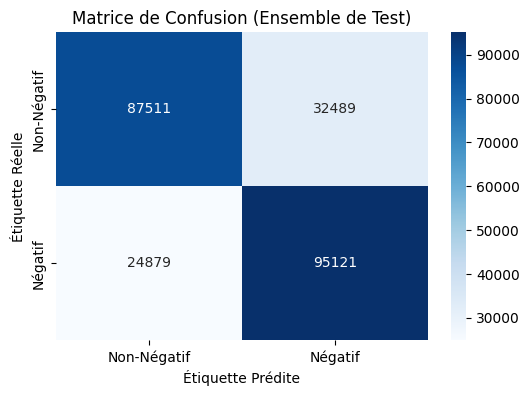


Métriques de test enregistrées dans l'exécution MLflow sélectionnée.


<Figure size 640x480 with 0 Axes>

In [64]:
print(
    f"\n--- Évaluation du Meilleur Modèle (ID de l'exécution : {BEST_RUN_ID}) sur l'ensemble de test ---"
)

# Chargement du meilleur modèle depuis MLflow
model_uri = f"runs:/{BEST_RUN_ID}/{MODEL_ARTIFACT_PATH}"
loaded_model = mlflow.tensorflow.load_model(model_uri)
print(f"Meilleur modèle chargé avec succès depuis : {model_uri}")

print("\nPrédiction sur l'ensemble de test...")
# Évaluation du modèle sur l'ensemble de test pour obtenir la perte et la précision
loss, accuracy = loaded_model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Perte de test : {loss:.4f}")
print(f"Précision de test : {accuracy:.4f}")

# Prédiction des probabilités et conversion en classes binaires (0 ou 1)
y_pred_proba = loaded_model.predict(X_test_pad)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Calcul des métriques de classification (précision, rappel, F1-score)
test_precision = precision_score(y_test, y_pred, zero_division=0)
test_recall = recall_score(y_test, y_pred, zero_division=0)
test_f1 = f1_score(y_test, y_pred, zero_division=0)

print(f"Précision de test : {test_precision:.4f}")
print(f"Rappel de test : {test_recall:.4f}")
print(f"Score F1 de test : {test_f1:.4f}")

print("\nRapport de classification (ensemble de test) :")
print(classification_report(y_test, y_pred))

print("\nMatrice de confusion (ensemble de test) :")
# Calcul et affichage de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Non-Négatif", "Négatif"],
    yticklabels=["Non-Négatif", "Négatif"],
)
plt.xlabel("Étiquette Prédite")
plt.ylabel("Étiquette Réelle")
plt.title("Matrice de Confusion (Ensemble de Test)")
plt.show()

# Enregistrement des métriques de test dans l'exécution MLflow
client.log_metric(BEST_RUN_ID, "test_loss", loss)
client.log_metric(BEST_RUN_ID, "test_accuracy", accuracy)
client.log_metric(BEST_RUN_ID, "test_precision", test_precision)
client.log_metric(BEST_RUN_ID, "test_recall", test_recall)
client.log_metric(BEST_RUN_ID, "test_f1", test_f1)
print("\nMétriques de test enregistrées dans l'exécution MLflow sélectionnée.")

# Sauvegarde et enregistrement de la matrice de confusion en tant qu'artefact MLflow
fig_path = "test_confusion_matrix.png"
plt.savefig(fig_path)
client.log_artifact(BEST_RUN_ID, fig_path)
# Suppression du fichier local de la figure après l'enregistrement
if os.path.exists(fig_path):
    os.remove(fig_path)

---

### <a id='toc6_3_'></a>[Enregistrement du model](#toc0_)

Cette cellule de code a pour objectif d'enregistrer le meilleur modèle entraîné dans le registre de modèles de MLflow sous le nom "MODEL_ADVANCED". L'enregistrement permet de versionner le modèle, de le suivre et de gérer son cycle de vie (par exemple, le déploiement en production). Une fois enregistré, les informations clés telles que le nom, la version et le stage actuel du modèle sont affichées.

In [67]:
# Enregistrement du modèle dans le registre de modèles MLflow
# L'URI pointe vers l'artefact "model" de la meilleure exécution
registered_model_info = mlflow.register_model(
    model_uri=f"runs:/{BEST_RUN_ID}/model", name="MODEL_ADVANCED"
)
print("Modèle enregistré avec succès :")
print(f"- Nom : {registered_model_info.name}")
print(f"- Version : {registered_model_info.version}")
print(f"- Stage : {registered_model_info.current_stage}")

Modèle enregistré avec succès :
- Nom : MODEL_ADVANCED
- Version : 3
- Stage : None


Registered model 'MODEL_ADVANCED' already exists. Creating a new version of this model...
Created version '3' of model 'MODEL_ADVANCED'.


---
---

## <a id='toc7_'></a>[Dashboard MLFlow](#toc0_)

In [68]:
! mlflow server --host 127.0.0.1 --port 8080

^C


![Overview](./mlflow_screenshot/advanced/Overview.png)

![Metrics](./mlflow_screenshot/advanced/Metrics.png)